# Description

* Quality control on MiSeq run data
  * post-merging
  * post-demultiplexing

# Setting variables

In [1]:
import os

baseDir = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/160713_FC2Unfrac'
workDir = os.path.join(baseDir, 'QC')
seqFile = os.path.join(baseDir, 'pear_merged-160713_FC2Unfrac.assembled.dmult.fastq')

# number of processors
nprocs = 20

# max expected error
maxee = 1

# Init

In [2]:
import re
import pandas as pd

In [3]:
%load_ext rpy2.ipython
#%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:dplyr’:

    combine


  warnings.warn(x, RRuntimeWarning)


In [5]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/160713_FC2Unfrac/QC


In [6]:
# symlinking demult seq file into CQ
tmp = os.path.join(baseDir, seqFile)
if not os.path.isfile(seqFile):
    tmp2 = os.path.split(tmp)[1]
    os.symlink(tmp, tmp2)
else:
    print ('File exists: {}'.format(os.path.join(workDir, seqFile)))

File exists: /home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/160713_FC2Unfrac/pear_merged-160713_FC2Unfrac.assembled.dmult.fastq


# Merged read quality filtering

## Discard sequences that exceed max expected error theshold

In [7]:
qcFile = os.path.split(seqFile)[1]
qcFile = os.path.splitext(qcFile)[0] + '_maxee{}.fasta'.format(maxee)
qcFile

'pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1.fasta'

In [8]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

mkdir /home/sam/tmp/tmpdir1
trap "rm -r /home/sam/tmp/tmpdir1" 1 2 3 15
split -d -l 2000000 $1 /home/sam/tmp/tmpdir1/Block

mkdir /home/sam/tmp/tmpdir2
trap "rm -r /home/sam/tmp/tmpdir2" 1 2 3 15
ls /home/sam/tmp/tmpdir1/Block?? | parallel --gnu -j $2 -k "usearch -fastq_filter {} -fastq_maxee $3 \
-fastaout /home/sam/tmp/tmpdir2/{#}.fasta >/dev/null 2>&1 && cat /home/sam/tmp/tmpdir2/{#}.fasta" > $4
rm -r /home/sam/tmp/tmpdir2 /home/sam/tmp/tmpdir1

In [9]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

printf "Max expected error cutoff: "
echo $3

printf "Number of sequence pre-filter: "
grep -c "orig_name=" $1

printf "Number of sequences post-filter: "
grep -c ">" $4

echo '' 
head -n 8 $4

Max expected error cutoff: 1
Number of sequence pre-filter: 4780891
Number of sequences post-filter: 4739947

>MR.A.13C-Ami.D6.R1_0 orig_name=M02465:296:000000000-ARUK4:1:1101:17204:1417
TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTGTTAAGACCGATTTGAAATCCC
CGGGCTCAACCTGGGAACTGCATTGGTGACTGGCAAGCTAGAGTATGGCAGAGGGGGGTAGAAATCCACGTGTAGCAGTG
AAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGCCAATACTGACGCTCATGCACGAGAGCGTG
GGGAGCAAACAGG
>MR.F.13C-Pal.D14.R1_1 orig_name=M02465:296:000000000-ARUK4:1:1101:14339:1418
CACGCAGGGCGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGACTGTCACGTCTGCTGTGAAAAGCT
GGGGCTTAACCCTGGCCTTGCAGTGGATACGGGCAGACTAGAGGTAGGTAGGGGAGAATGGAATTCCCGGTGTAGCGGTG


## Remove seqs with 'N' characters

In [10]:
qcFile2 = os.path.splitext(qcFile)[0] + '_noN.fasta'
qcFile2

'pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.fasta'

In [11]:
%%bash -s "$qcFile" "$qcFile2"

bioawk -c fastx '{if ($seq !~ /N/){print ">" $name " " $4 "\n" $seq}}' $1 > $2

printf "Number of sequence pre-filter: "
grep -c ">" $1

printf "Number of sequences post-filter: "
grep -c ">" $2

Number of sequence pre-filter: 4739947
Number of sequences post-filter: 4739946


## Alignment-based QC with Mothur

In [12]:
%%bash -s "$qcFile2"
# making mothur group file

perl -ne 'if(/^>/){ s/>(.+)(_\d+) .+/$1$2\t$1/; print;}' $1 > group_file.txt
head group_file.txt

MR.A.13C-Ami.D6.R1_0	MR.A.13C-Ami.D6.R1
MR.F.13C-Pal.D14.R1_1	MR.F.13C-Pal.D14.R1
MR.M.H2O-Con.D30.R2_3	MR.M.H2O-Con.D30.R2
MR.F.13C-Xyl.D3.R2_2	MR.F.13C-Xyl.D3.R2
MR.M.13C-Xyl.D3.R1_Frac18_4	MR.M.13C-Xyl.D3.R1_Frac18
MR.M.13C-Ami.D3.R1_5	MR.M.13C-Ami.D3.R1
MR.M.13C-Xyl.D6.R2_6	MR.M.13C-Xyl.D6.R2
MR.A.12C-Con.D3.R2_7	MR.A.12C-Con.D3.R2
MR.A.13C-Xyl.D3.R1_9	MR.A.13C-Xyl.D3.R1
MR.A.13C-Xyl.D3.R1_8	MR.A.13C-Xyl.D3.R1


In [13]:
! head -n 200 group_file.txt

MR.A.13C-Ami.D6.R1_0	MR.A.13C-Ami.D6.R1
MR.F.13C-Pal.D14.R1_1	MR.F.13C-Pal.D14.R1
MR.M.H2O-Con.D30.R2_3	MR.M.H2O-Con.D30.R2
MR.F.13C-Xyl.D3.R2_2	MR.F.13C-Xyl.D3.R2
MR.M.13C-Xyl.D3.R1_Frac18_4	MR.M.13C-Xyl.D3.R1_Frac18
MR.M.13C-Ami.D3.R1_5	MR.M.13C-Ami.D3.R1
MR.M.13C-Xyl.D6.R2_6	MR.M.13C-Xyl.D6.R2
MR.A.12C-Con.D3.R2_7	MR.A.12C-Con.D3.R2
MR.A.13C-Xyl.D3.R1_9	MR.A.13C-Xyl.D3.R1
MR.A.13C-Xyl.D3.R1_8	MR.A.13C-Xyl.D3.R1
MR.M.12C-Con.D1.R1_13	MR.M.12C-Con.D1.R1
MR.M.12C-Con.D30.R3_11	MR.M.12C-Con.D30.R3
MR.M.13C-Xyl.D3.R1_Frac20_12	MR.M.13C-Xyl.D3.R1_Frac20
MR.F.12C-Con.D6.R1_10	MR.F.12C-Con.D6.R1
MR.M.13C-Xyl.D3.R1_Frac20_15	MR.M.13C-Xyl.D3.R1_Frac20
MR.M.12C-Con.D1.R1_14	MR.M.12C-Con.D1.R1
MR.A.13C-Ami.D3.R1_18	MR.A.13C-Ami.D3.R1
MR.F.H2O-Con.D30.R3_19	MR.F.H2O-Con.D30.R3
MR.F.13C-Xyl.D14.R2_21	MR.F.13C-Xyl.D14.R2
MR.M.H2O-Con.D30.R2_20	MR.M.H2O-Con.D30.R2
MR.A.13C-Xyl.D3.R2_23	MR.A.13C-Xyl.D3.R2
MR.F.13C-Van.D6.R1_26	MR.F.13C-Van.D6.R1
MR.A.12C-Con.D0.R2_25	MR.A.12C-Con.D0.R2
MR.M.13C-Ami.

In [14]:
# unique sequences
cmd = 'mothur "#unique.seqs(fasta={})"'.format(qcFile2)
!$cmd | tail -n 30

4718000	3001630
4719000	3002177
4720000	3002775
4721000	3003346
4722000	3003907
4723000	3004491
4724000	3005129
4725000	3005715
4726000	3006294
4727000	3006887
4728000	3007490
4729000	3008101
4730000	3008691
4731000	3009315
4732000	3009935
4733000	3010596
4734000	3011234
4735000	3011975
4736000	3012663
4737000	3013313
4738000	3014026
4739000	3014725
4739946	3015452

Output File Names: 
pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.names
pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.fasta


mothur > quit()


In [15]:
qcFile3 = os.path.splitext(qcFile2)[0] + '.unique.fasta'
n_uniq = !grep -c ">" $qcFile3
print ('Number of unique sequences: {}'.format(n_uniq[0]))

Number of unique sequences: 3015452


In [16]:
# name file produced by unique.seqs()
nameFile = os.path.splitext(qcFile2)[0] + '.names'
!ls -thlc $nameFile

-rw-rw-r-- 1 sam sam 203M May 14 17:39 pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.names


In [17]:
%%bash 
# Remove database if already exsists
if [ -d mothur_silva_db ]; then
    rm -rf mothur_silva_db
fi

#if ! [ -d mothur_silva_db ]; then
#    mkdir mothur_silva_db
#fi

mkdir mothur_silva_db
cd mothur_silva_db

# Download mothur recreatd SEED database release 132.
wget https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
#wget https://www.mothur.org/w/images/a/a4/Silva.seed_v128.tgz
tar -xvzf Silva.seed_v132.tgz
rm Silva.seed_v132.tgz

silva.seed_v132.tax
silva.seed_v132.align
README.md


--2018-05-14 17:39:54--  https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
Resolving www.mothur.org (www.mothur.org)... 141.214.120.22
Connecting to www.mothur.org (www.mothur.org)|141.214.120.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19623900 (19M) [application/x-gzip]
Saving to: ‘Silva.seed_v132.tgz’

     0K .......... .......... .......... .......... ..........  0% 1.62M 12s
    50K .......... .......... .......... .......... ..........  0%  883K 17s
   100K .......... .......... .......... .......... ..........  0% 1.81M 14s
   150K .......... .......... .......... .......... ..........  1%  904K 16s
   200K .......... .......... .......... .......... ..........  1% 1.90M 15s
   250K .......... .......... .......... .......... ..........  1%  995K 15s
   300K .......... .......... .......... .......... ..........  1% 1.89M 15s
   350K .......... .......... .......... .......... ..........  2%  948K 15s
   400K .......... .......... .......

In [18]:
silvaFile = 'silva.seed_v132.align'
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(silvaFile, nprocs)
!cd mothur_silva_db; $cmd | tail -n 20

silvaFileFilt = os.path.splitext(silvaFile)[0] + '.filter.fasta'
silvaFileFilt = os.path.join('mothur_silva_db', silvaFileFilt)
ret = !grep -c ">" $silvaFileFilt
print ('\nNumber of sequences post-filter: {}'.format(ret[0]))

100
200
300
400
500
560



Length of filtered alignment: 10180
Number of columns removed: 39820
Length of the original alignment: 50000
Number of sequences used to construct filter: 11180

Output File Names: 
silva.filter
silva.seed_v132.filter.fasta


mothur > quit()

Number of sequences post-filter: 11180


In [19]:
# aligning sequences
qcFile3a = re.sub('-', '\-', qcFile3)
cmd = 'mothur "#align.seqs(candidate={}, template={}, processors=24, flip=T)"'.format(qcFile3a, silvaFileFilt)
!$cmd | tail -n 30

125400
125500
125600
125700
125800
125900
126000
126100
126200
126229
[WARNING]: Some of your sequences generated alignments that eliminated too many bases, a list is provided in pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.flip.accnos. If the reverse compliment proved to be better it was reported.
It took 1055 secs to align 3015452 sequences.


Output File Names: 
pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.align
pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.align.report
pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.flip.accnos


mothur > quit()


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Detected 1 [WARNING] messages, please review.
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<

In [20]:
qcFile4 = os.path.splitext(qcFile3)[0] + '.align'
!ls -thlc $qcFile4 

-rw-rw-r-- 1 sam sam 29G May 14 17:57 pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.align


In [21]:
# filtering out gap positions in the alignment
qcFile4a = re.sub('-', '\-', qcFile4)
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(qcFile4a, nprocs)
!$cmd | tail -n 30

149300
149400
149500
149600
149700
149800
149900
150000
150100
150200
150300
150400
150500
150600
150700
150793



Length of filtered alignment: 1187
Number of columns removed: 8993
Length of the original alignment: 10180
Number of sequences used to construct filter: 3015452

Output File Names: 
pear_merged-160713_FC2Unfrac.filter
pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.filter.fasta


mothur > quit()


In [22]:
qcFile5 = os.path.splitext(qcFile3)[0] + '.filter.fasta'
!ls -thlc $qcFile5

-rw-rw-r-- 1 sam sam 3.5G May 14 17:59 pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.filter.fasta


In [23]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={}, name={})"'.format(qcFile5, nprocs, nameFile)
!$cmd | tail -n 20

Using 20 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	0	0	0	0	1	1
2.5%-tile:	178	919	253	0	4	118499
25%-tile:	178	919	253	0	4	1184987
Median: 	178	919	253	0	5	2369974
75%-tile:	178	919	253	0	5	3554960
97.5%-tile:	178	919	254	0	7	4621448
Maximum:	1187	1187	341	0	79	4739946
Mean:	178.31	918.963	252.983	0	4.85735
# of unique seqs:	3015452
total # of seqs:	4739946

Output File Names: 
pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.filter.summary

It took 15 secs to summarize 4739946 sequences.

mothur > quit()


## Removing homopolymers (> 8) and screening out sequences that don't align to an amplicon region

In [24]:
cmd = """mothur '#screen.seqs(fasta={},\
    processors={},\
    name={},\
    group={},\
    start={},\
    end={},\
    maxhomop=8)'""".format(qcFile5, nprocs, nameFile, 'group_file.txt', 178, 919)
!$cmd | tail -n 30

Processing sequence: 150863
g sequence: 149300
Processing sequence: 149400
Processing sequence: 149500
Processing sequence: 149600
Processing sequence: 149700
Processing sequence: 149800
Processing sequence: 149900
Processing sequence: 150000
Processing sequence: 150100
Processing sequence: 150200
Processing sequence: 150300
Processing sequence: 150400
Processing sequence: 150500
Processing sequence: 150600
Processing sequence: 150700
Processing sequence: 150800
Processing sequence: 150900
Processing sequence: 150936

Output File Names: 
pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.filter.good.fasta
pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.filter.bad.accnos
pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.good.names
group_file.good.txt


It took 28 secs to screen 3015452 sequences.

mothur > quit()


In [25]:
qcFile6 = os.path.splitext(qcFile5)[0] + '.good.fasta'
ret = !grep -c ">" $qcFile6
print ('Number of sequences post-filter: {}'.format(ret[0]))

Number of sequences post-filter: 2957746


In [26]:
qcFile6a = re.sub('-', '\-', qcFile6)
cmd = 'mothur "#filter.seqs(fasta={}, processors={}, vertical=T)"'.format(qcFile6a, nprocs)
!$cmd | tail -n 20

147600
147700
147800
147900
148000
148048



Length of filtered alignment: 903
Number of columns removed: 284
Length of the original alignment: 1187
Number of sequences used to construct filter: 2957746

Output File Names: 
pear_merged-160713_FC2Unfrac.filter
pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


mothur > quit()


In [27]:
qcFile7 = os.path.splitext(qcFile6)[0] + '.filter.fasta'
!ls -thlc $qcFile7

-rw-rw-r-- 1 sam sam 2.6G May 14 18:00 pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


## Deunique seqs

In [28]:
cmd = 'mothur "#deunique.seqs(fasta={}, name={})"'.format(qcFile7, nameFile)
!$cmd | tail -n 30

mothur v.1.39.5
Last updated: 3/20/2017

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

For questions and analysis support, please visit our forum at https://www.mothur.org/forum

Type 'quit()' to exit program



mothur > deunique.seqs(fasta=pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta, name=pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.names)

Output File Names: 
pear_merged-160713_FC2Unfrac.assembled.dmult_maxee1_noN.unique.filter.good.filter.redundant.fasta


mothur > quit()


### Final QC-ed file

In [29]:
qcFile8 = os.path.splitext(qcFile7)[0] + '.redundant.fasta'
qcFinal = 'finalQC.fasta'
!perl -pe 's/[-.]//g if ! /^>/' $qcFile8 > $qcFinal

In [30]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={})"'.format(qcFinal, nprocs)
!$cmd | tail -n 20


Using 20 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	213	213	0	3	1
2.5%-tile:	1	253	253	0	4	116461
25%-tile:	1	253	253	0	4	1164607
Median: 	1	253	253	0	5	2329213
75%-tile:	1	253	253	0	5	3493819
97.5%-tile:	1	254	254	0	7	4541965
Maximum:	1	341	341	0	8	4658425
Mean:	1	253.089	253.089	0	4.83847
# of Seqs:	4658425

Output File Names: 
finalQC.summary

It took 5 secs to summarize 4658425 sequences.

mothur > quit()


In [31]:
!head -n 6 $qcFinal

>MR.A.13C-Ami.D6.R1_0
TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTGTTAAGACCGATTTGAAATCCCCGGGCTCAACCTGGGAACTGCATTGGTGACTGGCAAGCTAGAGTATGGCAGAGGGGGGTAGAAATCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGCCAATACTGACGCTCATGCACGAGAGCGTGGGGAGCAAACAGG
>MR.F.13C-Pal.D14.R1_1
CACGCAGGGCGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGACTGTCACGTCTGCTGTGAAAAGCTGGGGCTTAACCCTGGCCTTGCAGTGGATACGGGCAGACTAGAGGTAGGTAGGGGAGAATGGAATTCCCGGTGTAGCGGTGAAATGCGCAGATATCGGGAGGAACACCGGTGGCGAAGGCGGTTCTCTGGGCCTTACCTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACAGG
>MR.F.13C-Ami.D14.R1_575877
CACGCAGGGCGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGACTGTCACGTCTGCTGTGAAAAGCTGGGGCTTAACCCTGGCCTTGCAGTGGATACGGGCAGACTAGAGGTAGGTAGGGGAGAATGGAATTCCCGGTGTAGCGGTGAAATGCGCAGATATCGGGAGGAACACCGGTGGCGAAGGCGGTTCTCTGGGCCTTACCTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACAGG


## Summary of number of seqs per sample

In [32]:
re1 = re.compile('_[0-9]+$')

qcFinalSum = os.path.splitext(qcFinal)[0] + '.summary'

samp_count = dict()
with open(qcFinalSum, 'r') as inFH:
    for line in inFH:
        if line.startswith('seqname'):
            continue
        line = line.rstrip().split('\t')
        line[0] = re.sub(re1, '', line[0])
        try:
            samp_count[line[0]] += 1
        except KeyError:
            samp_count[line[0]] = 1

In [33]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(samp_count, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

,Sample,seq_count
0,MR.A.13C-Ami.D6.R1,98852
1,MR.F.13C-Pal.D14.R1,17892
2,MR.F.13C-Ami.D14.R1,44065
3,MR.F.13C-Xyl.D6.R1,14366
4,MR.A.13C-Cel.D6.R1,57832
5,MR.F.13C-Xyl.D14.R2,37035
6,MR.F.12C-Con.D6.R2,108518
7,MR.F.13C-Pal.D30.R3,15042
8,MR.M.H2O-Con.D30.R2,33272
9,MR.M.13C-Pal.D6.R2,28496


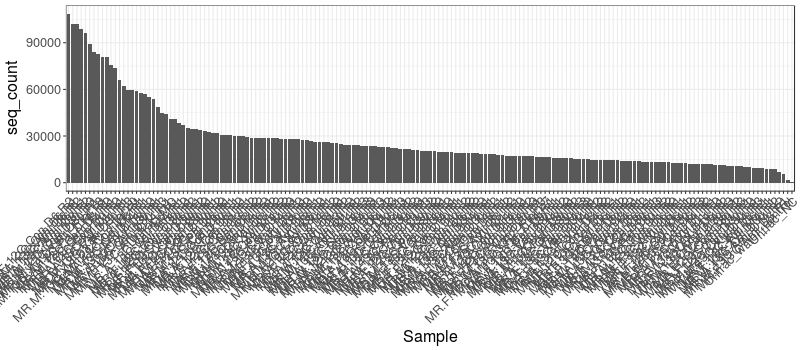

In [34]:
%%R -i df_seq_cnt -w 800 -h 350
# plotting all

df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)


df_seq_cnt = df_seq_cnt %>% 
    #mutate(H2O = grepl('_F0$', Sample)) %>%
    mutate(rank = min_rank(seq_count)) %>%
    arrange(desc(rank))

df_seq_cnt$Sample = factor(df_seq_cnt$Sample, levels=df_seq_cnt$Sample)

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [36]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 10000,]

                  Sample seq_count rank
161  MR.M.12C-Con.D30.R2      9832   11
162  MR.F.H2O-Con.D30.R1      9554   10
163  MR.M.13C-Xyl.D14.R3      9410    9
164   MR.F.13C-Xyl.D3.R1      9299    8
165   MR.F.13C-Pal.D6.R1      9054    7
166  MR.M.13C-Xyl.D14.R1      8659    6
167  MR.A.13C-Cel.D30.R2      8627    5
168  MR.M.13C-Ami.D14.R2      6733    4
169   MR.F.13C-Ami.D3.R1      5597    3
170 Unfrac_water_control      1759    2
171            Unfrac_NC       456    1
